<a href="https://colab.research.google.com/github/nilsugungor/titanic-analysis/blob/main/titanic_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("yasserh/titanic-dataset")

100%|██████████| 22.0k/22.0k [00:00<00:00, 14.5MB/s]

Extracting files...


In [3]:
import pandas as pd
import os
df = pd.read_csv(os.path.join(path, "Titanic-Dataset.csv"))
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [5]:
df.drop('Cabin', axis=1, inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
#dropped cabin completeky, filled embarked with mode, age null values are in total 177 so for now im not touching them

/tmp/ipython-input-1815856018.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


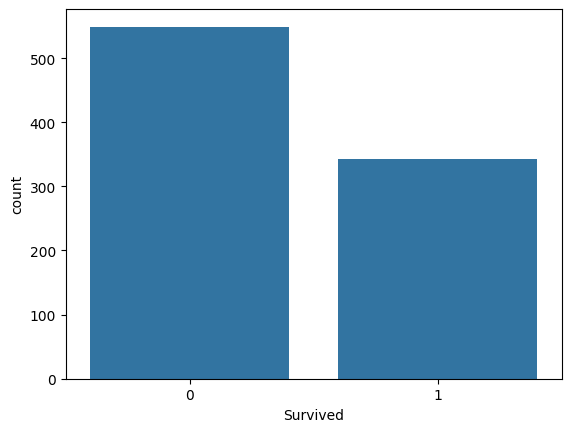

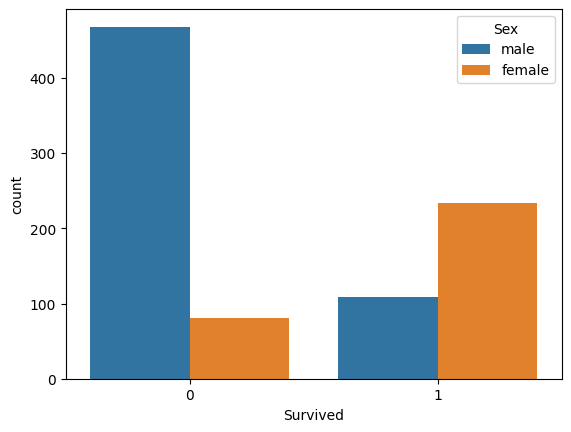

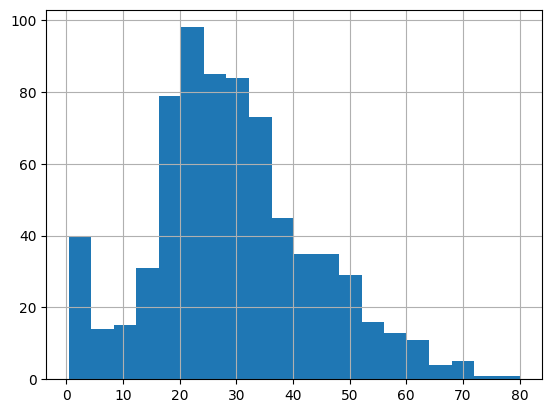

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="Survived")
plt.show()

sns.countplot(data=df, x="Survived", hue="Sex")
plt.show()

df["Age"].hist(bins=20)
plt.show()

In [7]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

df["AgeGroup"] = pd.cut(df["Age"], bins=[0, 12, 20, 40, 60, 100], labels=["Child","Teen","Adult","Middle","Senior"])

#family size = siblings + spouse // parents + children // plus themselves
#age group in 5 bins

In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,Adult


In [10]:
age_survival = df.groupby("AgeGroup", observed=False)["Survived"].mean()
#mean to represent the percentage of survival

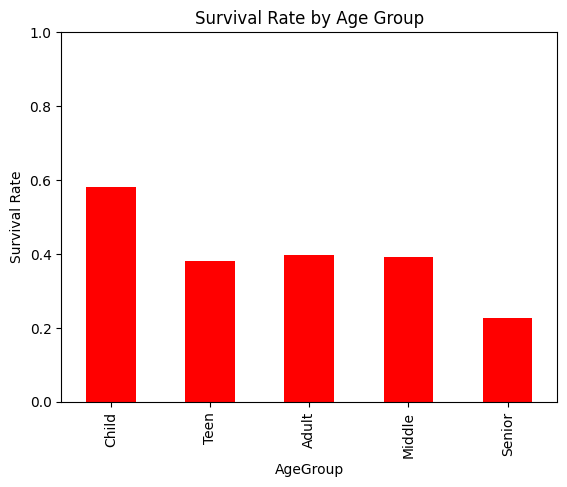

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

age_survival.plot(kind="bar", color="red")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Age Group")
plt.ylim(0, 1)
plt.show()


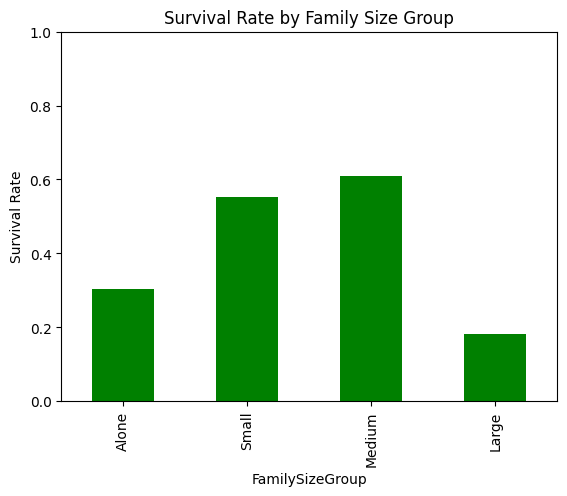

In [14]:
df["FamilySizeGroup"] = pd.cut(df["FamilySize"], bins=[0,1,2,4,10], labels=["Alone","Small","Medium","Large"])

family_survival = df.groupby("FamilySizeGroup", observed=False)["Survived"].mean()

family_survival.plot(kind="bar", color="green")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Family Size Group")
plt.ylim(0,1)
plt.show()


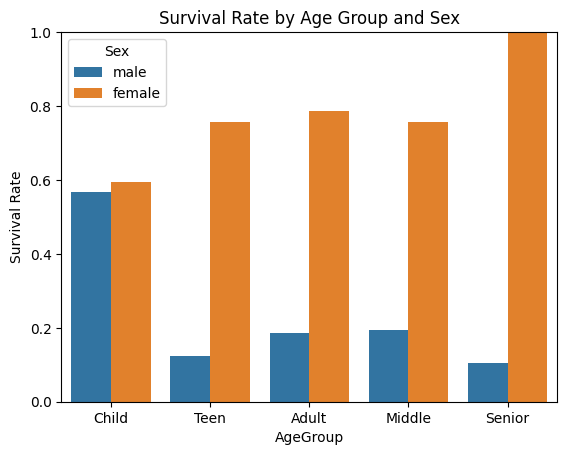

In [16]:
sns.barplot(data=df, x="AgeGroup", y="Survived", hue="Sex", errorbar=None)
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Age Group and Sex")
plt.ylim(0,1)
plt.show()


In [26]:
#fare binning, decreased the accuracy, if i need to add this i need to make a lot more bins so gonna skip for randomforest model
df['FareGroup'] = pd.cut(df['Fare'],
                         bins=[0, 7.91, 14.454, 31, 512],
                         labels=['Low', 'Medium', 'High', 'VeryHigh'])
df = pd.get_dummies(df, columns=['FareGroup'], drop_first=True)


In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


#df = pd.get_dummies(df, columns=["Embarked", "AgeGroup"], drop_first=True) #one hot encoding

X = df[["Pclass", "Sex", "Age", "FamilySize", "Fare"] +
       [col for col in df.columns if "Embarked_" in col or "AgeGroup_" in col]].copy()

X["Sex"] = X["Sex"].map({"male": 0, "female": 1})
X["Age"] = X["Age"].fillna(X["Age"].median())

y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8379888268156425
